In [1]:
!pip install pymc_marketing==0.3.1 lifetimes arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 919.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from arviz.labels import MapLabeller

from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from pymc_marketing import clv


In [2]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

In [3]:
data = load_cdnow_summary_data_with_monetary_value()
data['customer_id'] = data.index
data

,frequency,recency,T,monetary_value,customer_id
customer_id,,,,,
1,2,30.43,38.86,22.35,1
2,1,1.71,38.86,11.77,2
3,0,0.00,38.86,0.00,3
4,0,0.00,38.86,0.00,4
5,0,0.00,38.86,0.00,5
...,...,...,...,...,...
2353,0,0.00,27.00,0.00,2353
2354,5,24.29,27.00,44.93,2354
2355,0,0.00,27.00,0.00,2355


In [4]:
bgm = clv.BetaGeoModel(
data = data
)

bgm.build_model()
bgm


BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

In [5]:
model_config = {
    'a_prior': {
        'dist': 'HalfNormal',
        'kwargs': {'sigma': 10}
    },
    'b_prior': {
        'dist': 'HalfNormal',
        'kwargs': {'sigma': 10}
    },
    'alpha_prior': {
        'dist': 'HalfNormal',
        'kwargs': {'sigma': 10}
    },
    'r_prior': {
        'dist': 'HalfNormal',
        'kwargs': {'sigma': 10}
    }
}

bgm = clv.BetaGeoModel(
    data = data,
    model_config=model_config
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

In [6]:
bgm.fit()

bgm.fit_summary()


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.961,0.259,0.541,1.432,0.010,0.007,836.0,625.0,1.0
b,3.137,1.079,1.501,4.979,0.041,0.030,837.0,745.0,1.0
alpha,4.476,0.400,3.779,5.232,0.013,0.009,986.0,1115.0,1.0
r,0.244,0.013,0.221,0.269,0.000,0.000,976.0,971.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


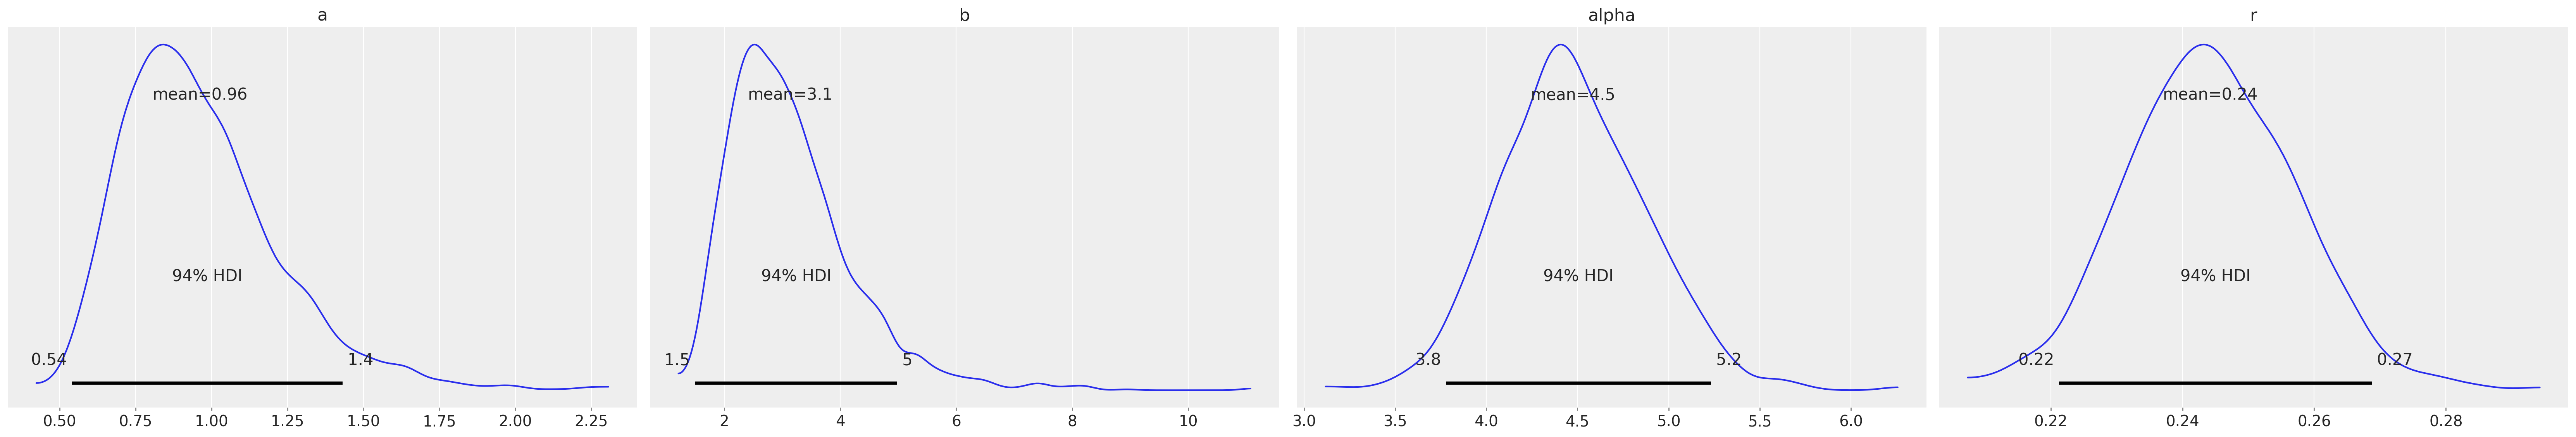

In [7]:
az.plot_posterior(bgm.fit_result);

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

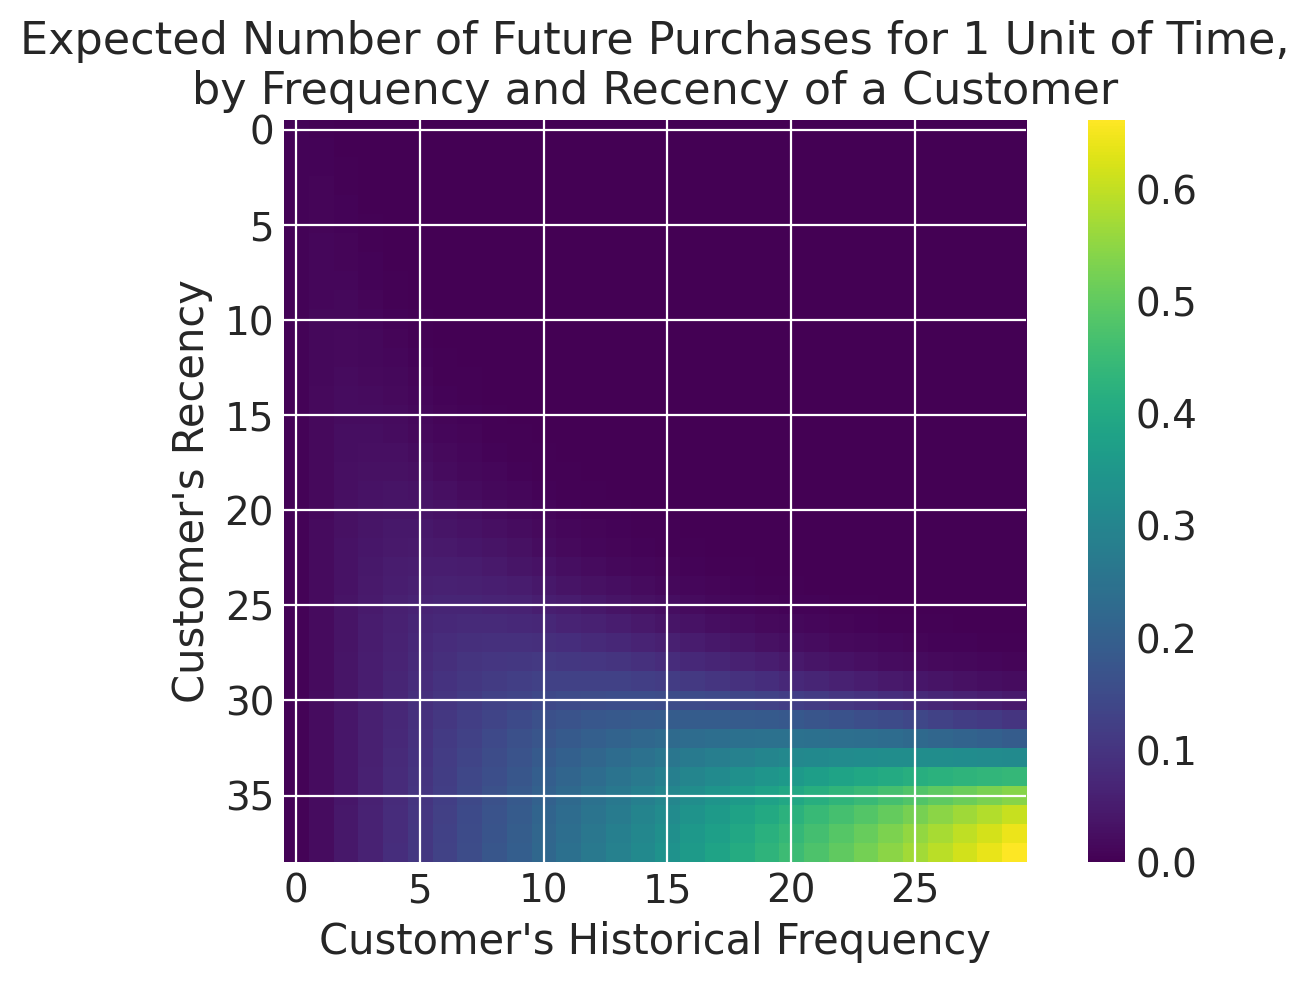

In [8]:
clv.plot_frequency_recency_matrix(bgm)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

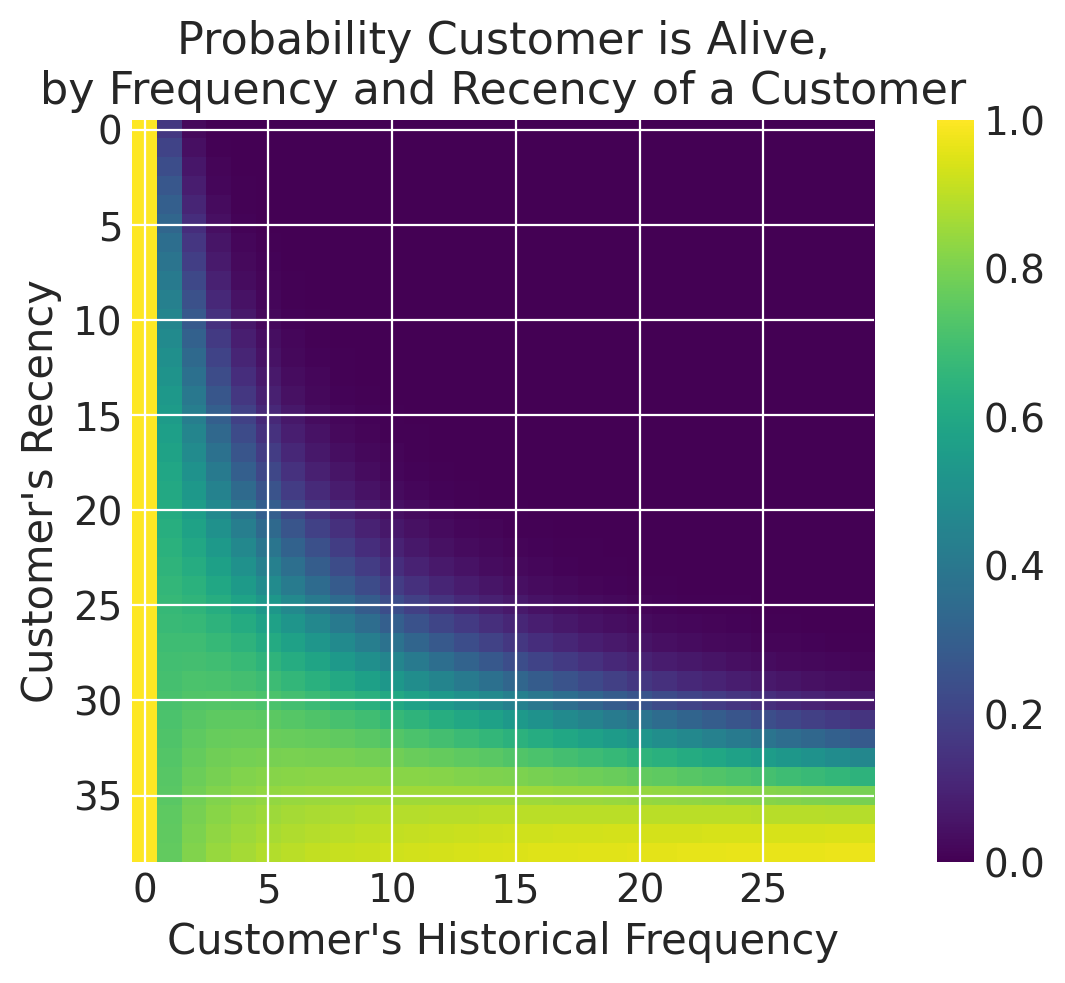

In [9]:
clv.plot_probability_alive_matrix(bgm)

In [10]:
num_purchases = bgm.expected_num_purchases(

customer_id = data.index,

t = 1,

frequency=data["frequency"],

recency=data["recency"],

T=data["T"]

)


In [11]:
sdata = data.copy()

sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values


In [12]:

sdata.sort_values(by="expected_purchases").tail(10)


,frequency,recency,T,monetary_value,customer_id,expected_purchases
customer_id,,,,,,
1017,12,32.43,33.43,12.86,1017,0.292605
693,13,34.43,35.00,42.44,693,0.308801
813,13,33.86,34.29,28.62,813,0.315375
1413,14,30.29,31.57,19.01,1413,0.355952
1539,14,29.86,30.86,18.13,1539,0.366315
509,18,35.14,35.86,78.63,509,0.420270
841,19,34.00,34.14,29.49,841,0.470439
1981,17,28.43,28.86,48.23,1981,0.481251
157,29,37.71,38.00,26.26,157,0.657041


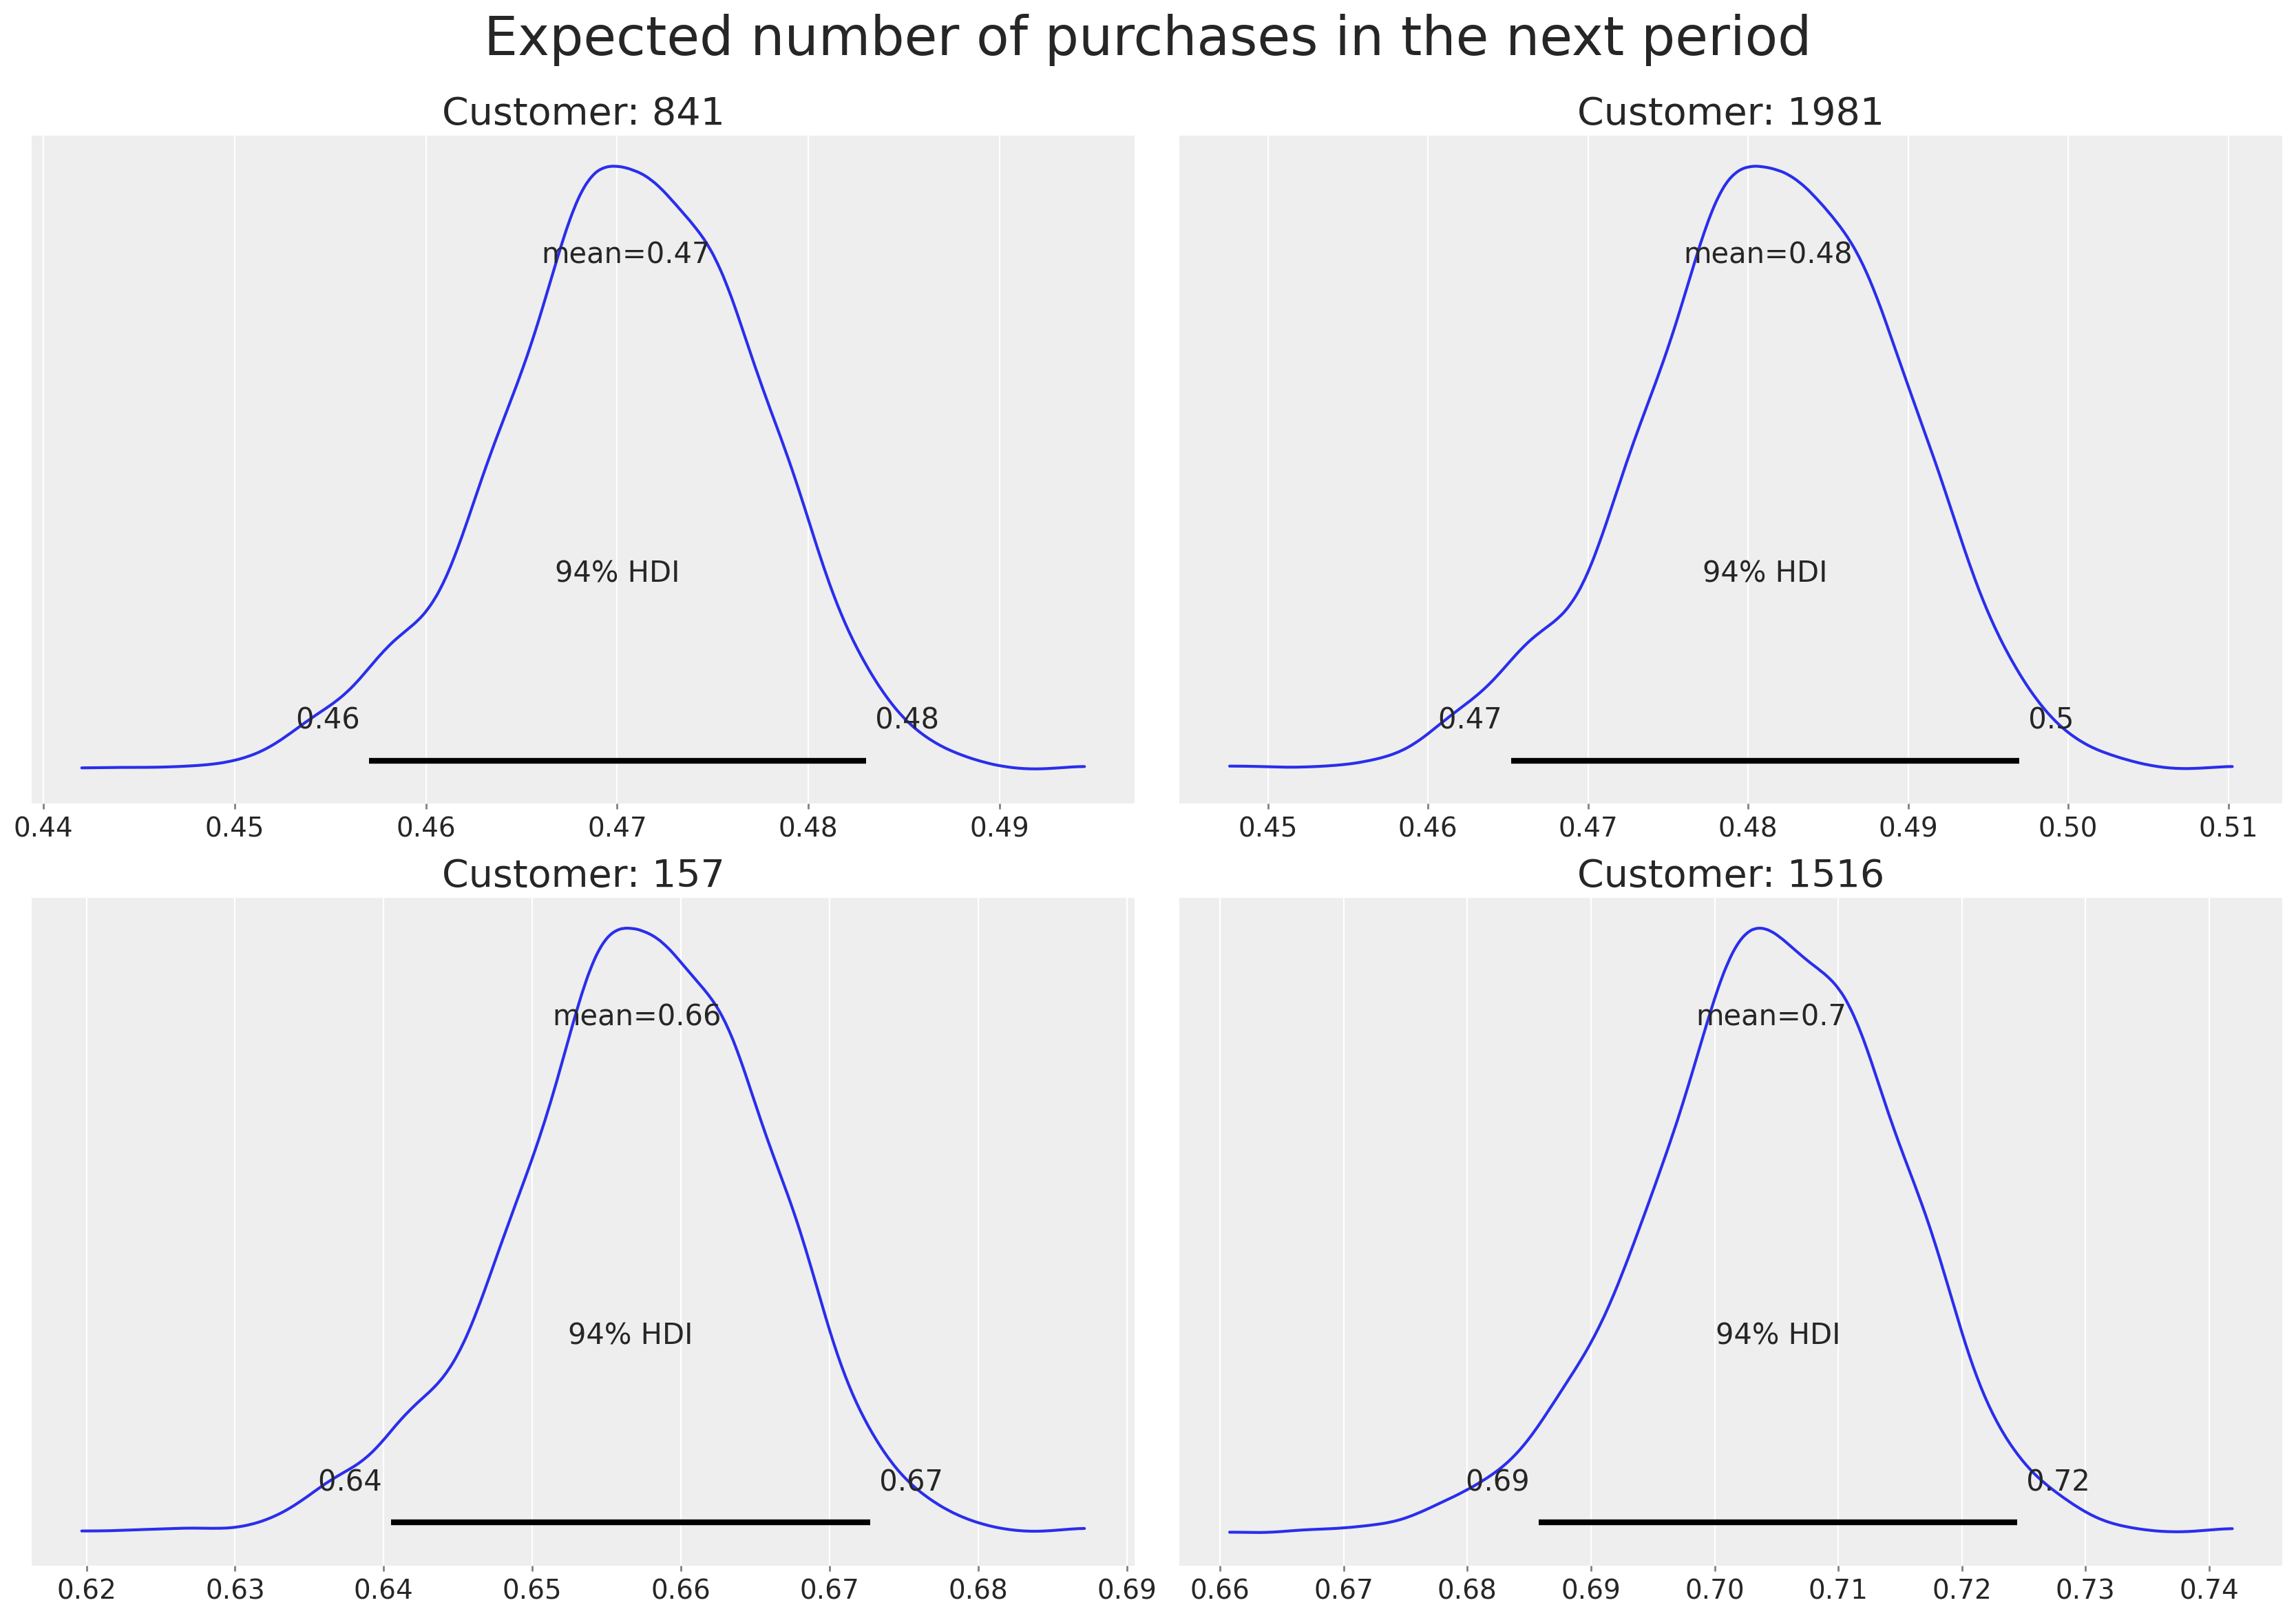

In [13]:
ids = [841, 1981, 157, 1516]

ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));

for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}", size=20)



plt.suptitle("Expected number of purchases in the next period", fontsize=28, y=1.05);


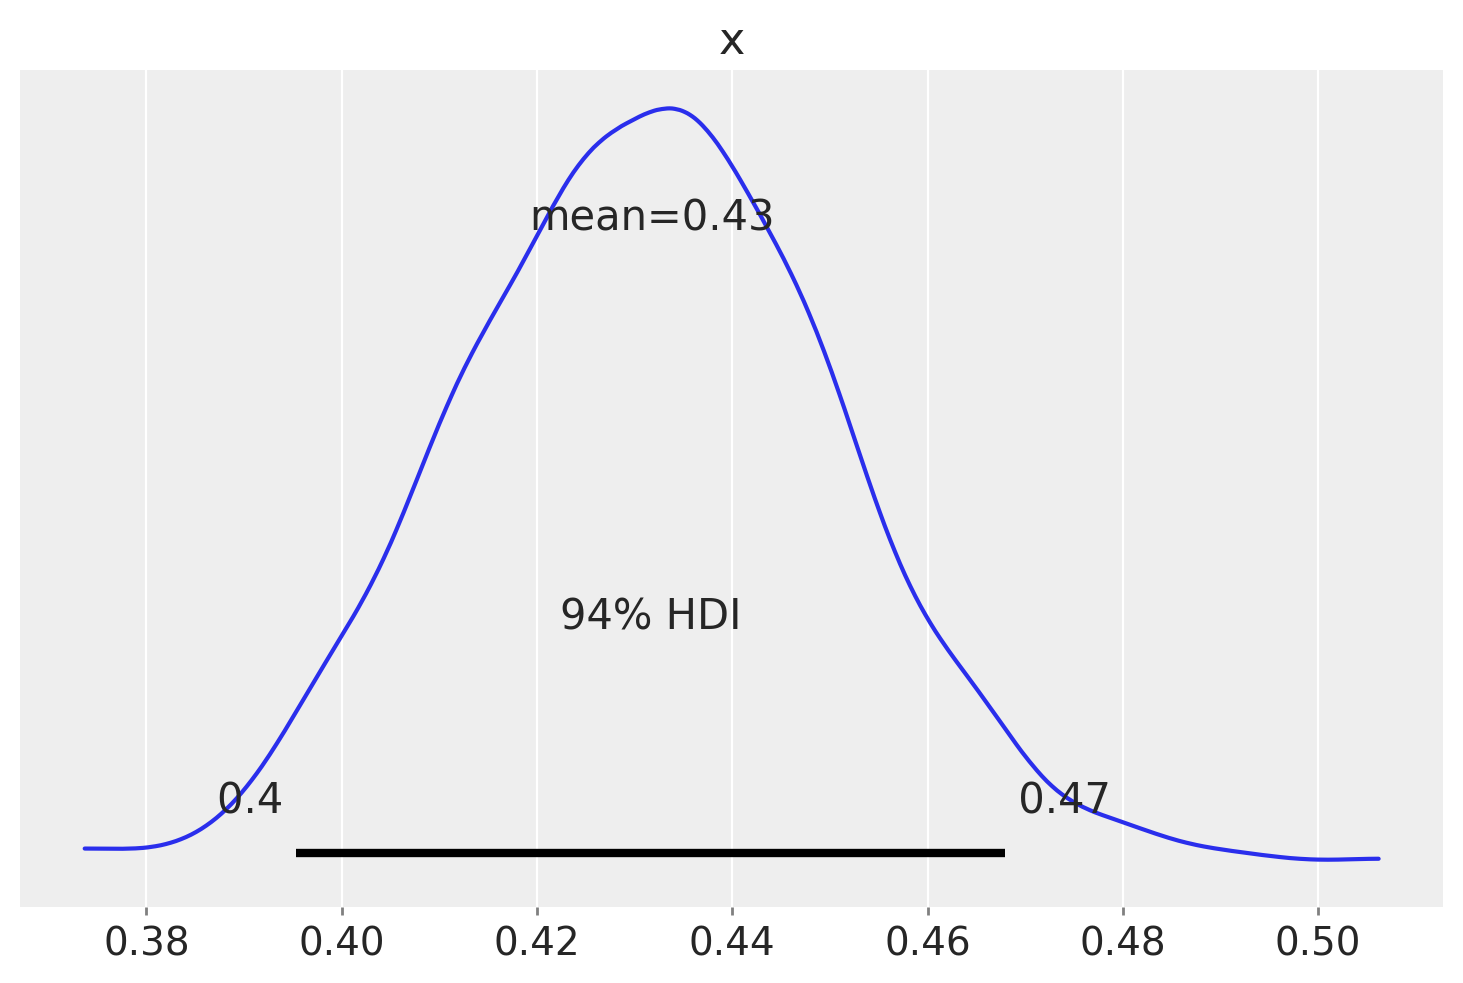

In [14]:
az.plot_posterior(

bgm.expected_num_purchases_new_customer(t=10)

);


In [15]:
customer_1516 = data.loc[1516]

customer_1516


frequency           26.00
recency             30.86
T                   31.00
monetary_value      39.97
customer_id       1516.00
Name: 1516, dtype: float64

In [16]:
customer_1516_history = pd.DataFrame(

dict(

ID=np.full(10, 1516, dtype="int"),

frequency=np.full(10, customer_1516["frequency"], dtype="int"),

recency=np.full(10, customer_1516["recency"]),

T=(np.arange(-1, 9) + customer_1516["T"]).astype("int")

)

)

customer_1516_history


,ID,frequency,recency,T
0,1516,26,30.86,30
1,1516,26,30.86,31
2,1516,26,30.86,32
3,1516,26,30.86,33
4,1516,26,30.86,34
5,1516,26,30.86,35
6,1516,26,30.86,36
7,1516,26,30.86,37
8,1516,26,30.86,38
9,1516,26,30.86,39


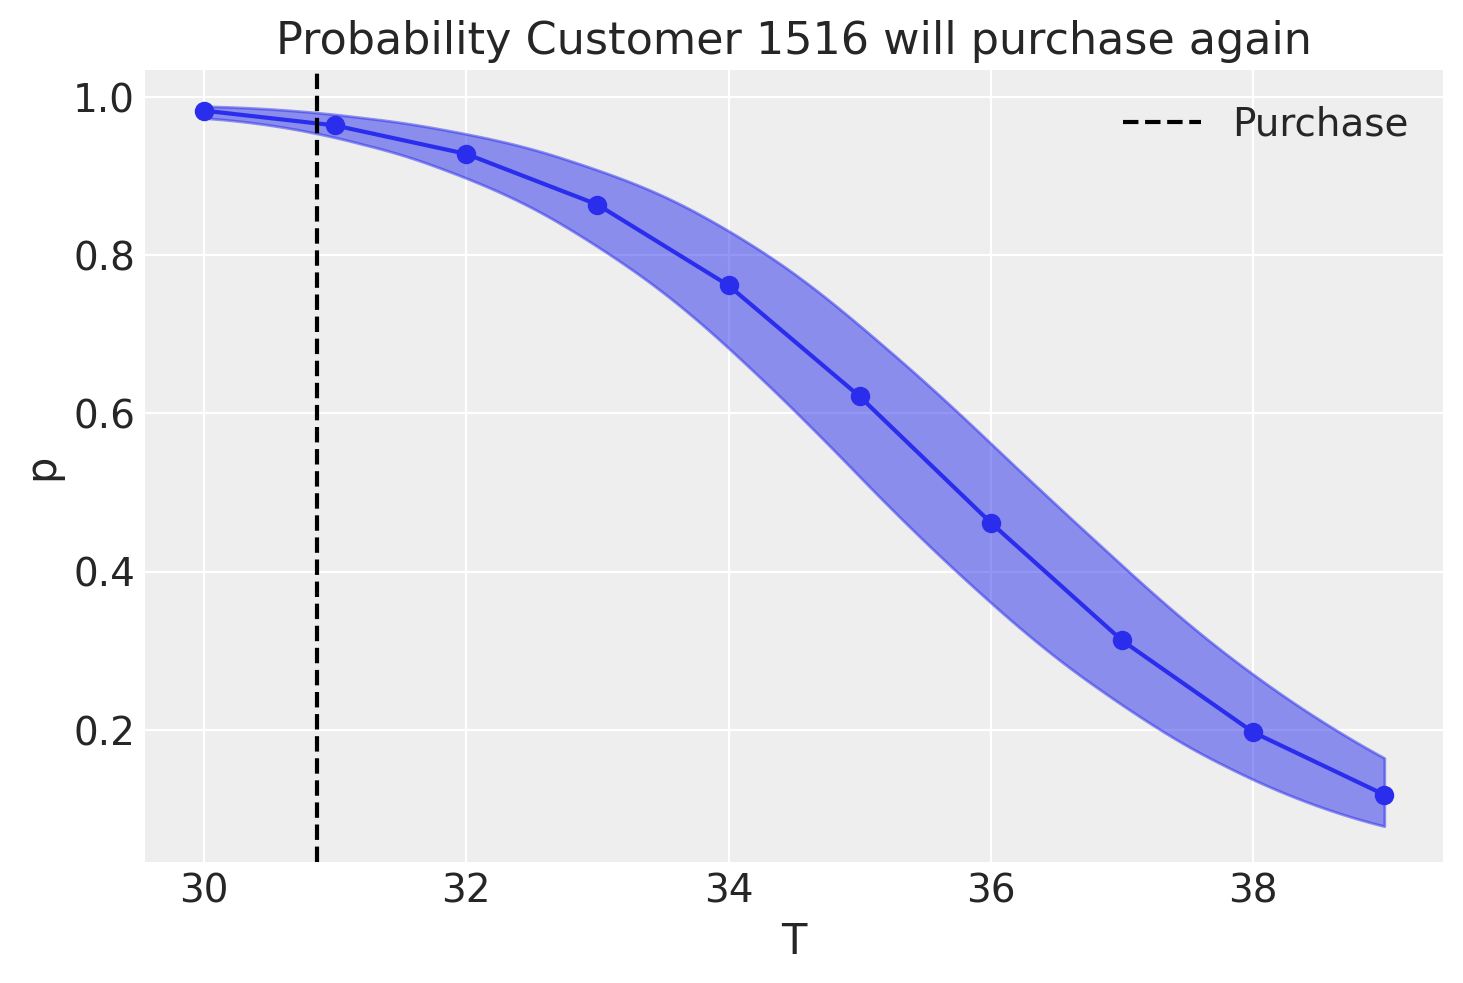

In [17]:
p_alive = bgm.expected_probability_alive(

customer_id = customer_1516_history["ID"],

frequency = customer_1516_history["frequency"],

recency = customer_1516_history["recency"],

T = customer_1516_history["T"],

)

az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")

plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker = "o")

plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")



plt.title("Probability Customer 1516 will purchase again")

plt.xlabel("T")

plt.ylabel("p")

plt.legend();


In [18]:
customer_1516_history["frequency"].iloc[-3:] += 1

customer_1516_history["recency"].iloc[-3:] = customer_1516_history["T"].iloc[-3] - 0.5

customer_1516_history


,ID,frequency,recency,T
0,1516,26,30.86,30
1,1516,26,30.86,31
2,1516,26,30.86,32
3,1516,26,30.86,33
4,1516,26,30.86,34
5,1516,26,30.86,35
6,1516,26,30.86,36
7,1516,27,36.50,37
8,1516,27,36.50,38
9,1516,27,36.50,39


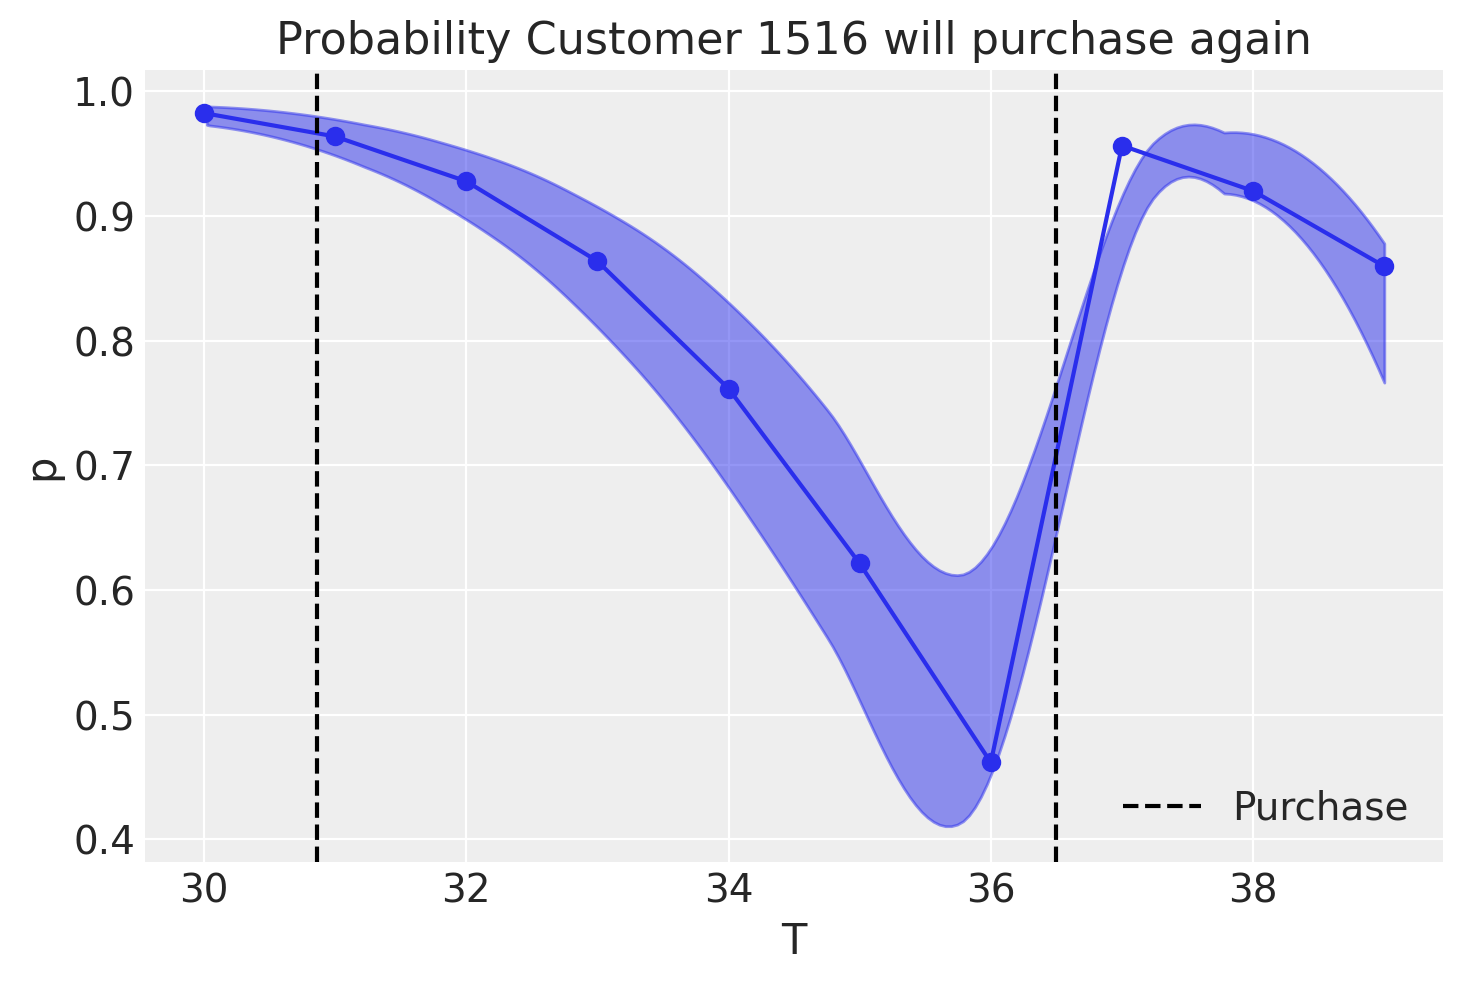

In [19]:
p_alive = bgm.expected_probability_alive(

customer_id = customer_1516_history["ID"],

frequency = customer_1516_history["frequency"],

recency = customer_1516_history["recency"],

T = customer_1516_history["T"],

)

az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")

plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker = "o")

plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.axvline(customer_1516_history["recency"].iloc[-1], c="black", ls="--")



plt.title("Probability Customer 1516 will purchase again")

plt.xlabel("T")

plt.ylabel("p")

plt.legend();


In [20]:
nonzero_data = data.query("frequency>0")

nonzero_data


,frequency,recency,T,monetary_value,customer_id
customer_id,,,,,
1,2,30.43,38.86,22.35,1
2,1,1.71,38.86,11.77,2
6,7,29.43,38.86,73.74,6
7,1,5.00,38.86,11.77,7
9,2,35.71,38.86,25.55,9
...,...,...,...,...,...
2348,7,24.14,27.00,16.36,2348
2349,1,9.29,27.00,13.97,2349
2350,2,21.86,27.00,18.56,2350


In [21]:
dataset = pd.DataFrame({

"customer_id": nonzero_data.index,

"mean_transaction_value": nonzero_data["monetary_value"],

"frequency": nonzero_data["frequency"]

})



gg = clv.GammaGammaModel(

data = dataset

)

gg.build_model()

gg


Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [22]:
gg.fit()
gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.389,1.277,4.357,8.797,0.064,0.045,407.0,509.0,1.0
q,3.785,0.288,3.303,4.342,0.012,0.009,539.0,879.0,1.0
v,16.100,4.236,9.088,24.387,0.211,0.149,400.0,490.0,1.0


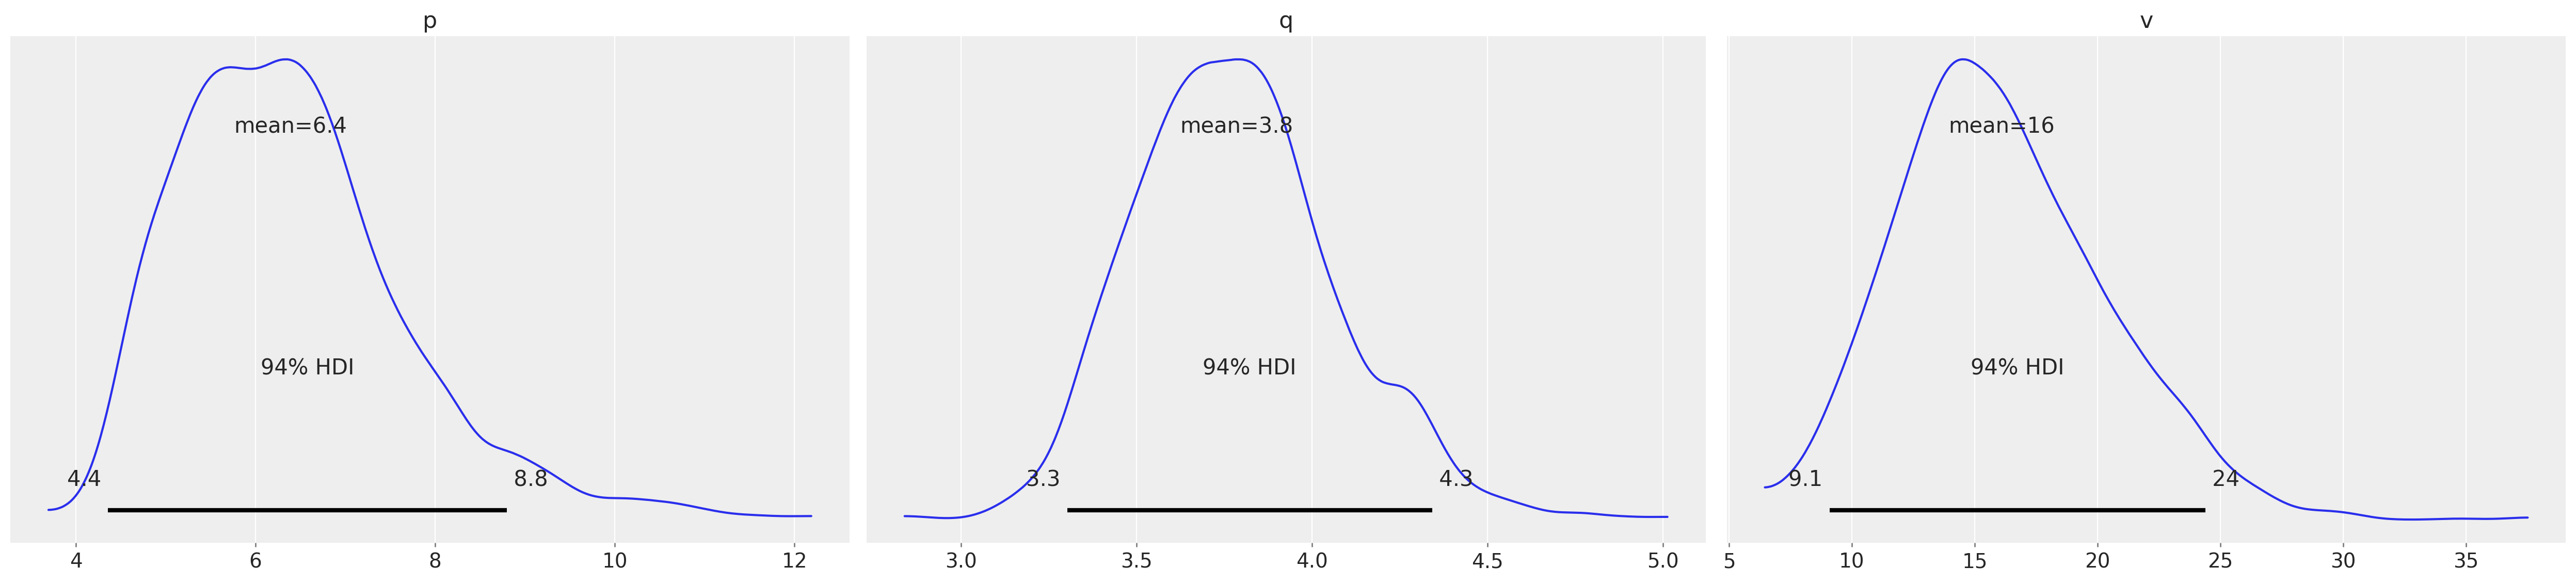

In [23]:
az.plot_posterior(gg.fit_result);

In [24]:
expected_spend = gg.expected_customer_spend(

customer_id = data.index,

mean_transaction_value=data["monetary_value"],

frequency=data["frequency"]

)

az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")


,mean,sd,hdi_3%,hdi_97%
x[1],24.713,0.511,23.808,25.718
x[2],19.011,1.306,16.628,21.469
x[3],35.202,0.901,33.541,36.887
x[4],35.202,0.901,33.541,36.887
x[5],35.202,0.901,33.541,36.887
x[6],71.382,0.598,70.231,72.402
x[7],19.011,1.306,16.628,21.469
x[8],35.202,0.901,33.541,36.887
x[9],27.323,0.393,26.594,28.071
x[10],35.202,0.901,33.541,36.887


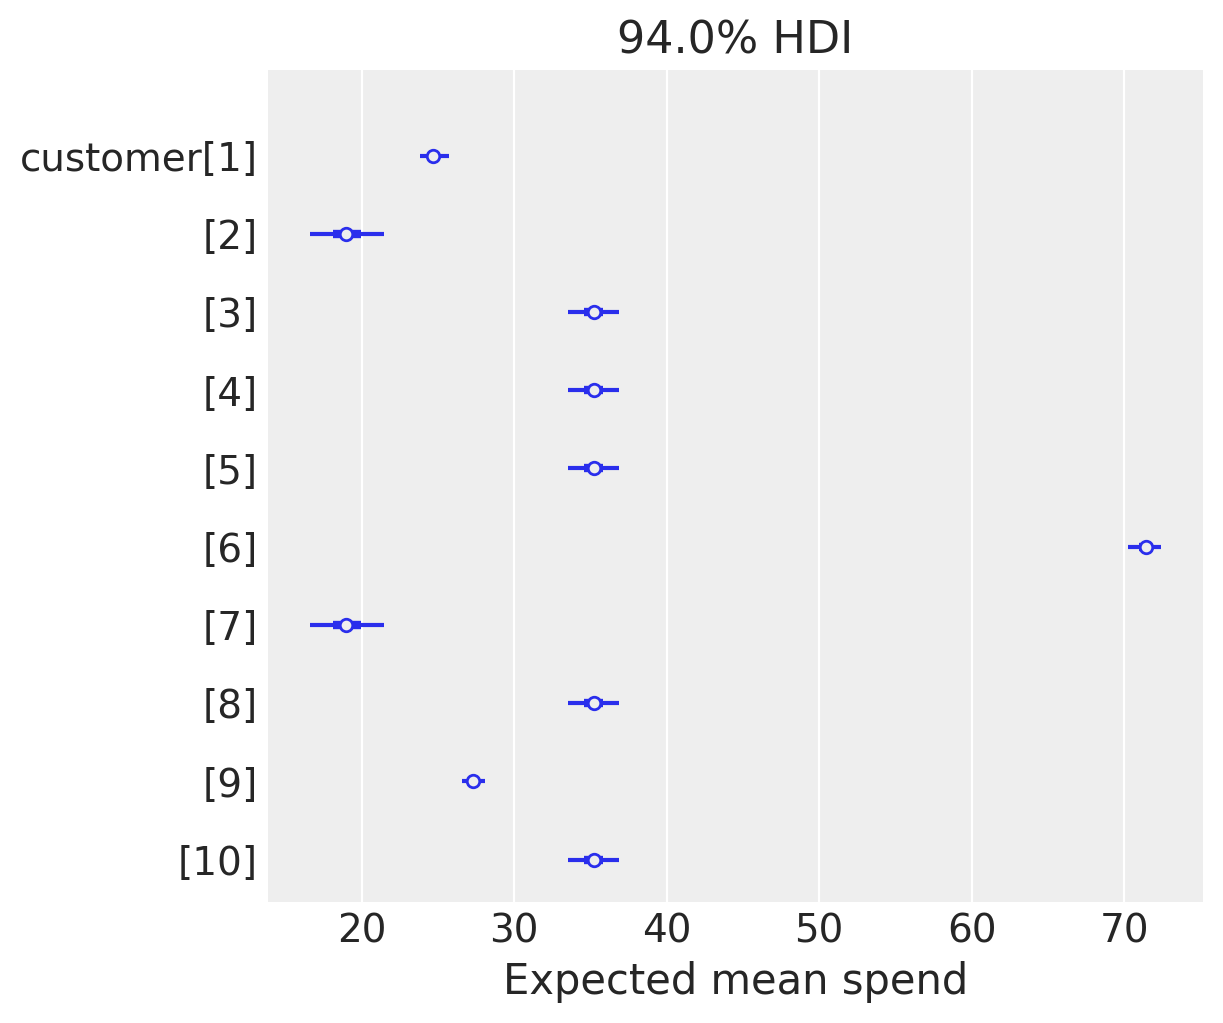

In [25]:
labeller = MapLabeller(var_name_map={"x": "customer"})

az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)

plt.xlabel("Expected mean spend");


In [26]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.273,0.614,34.139,36.415


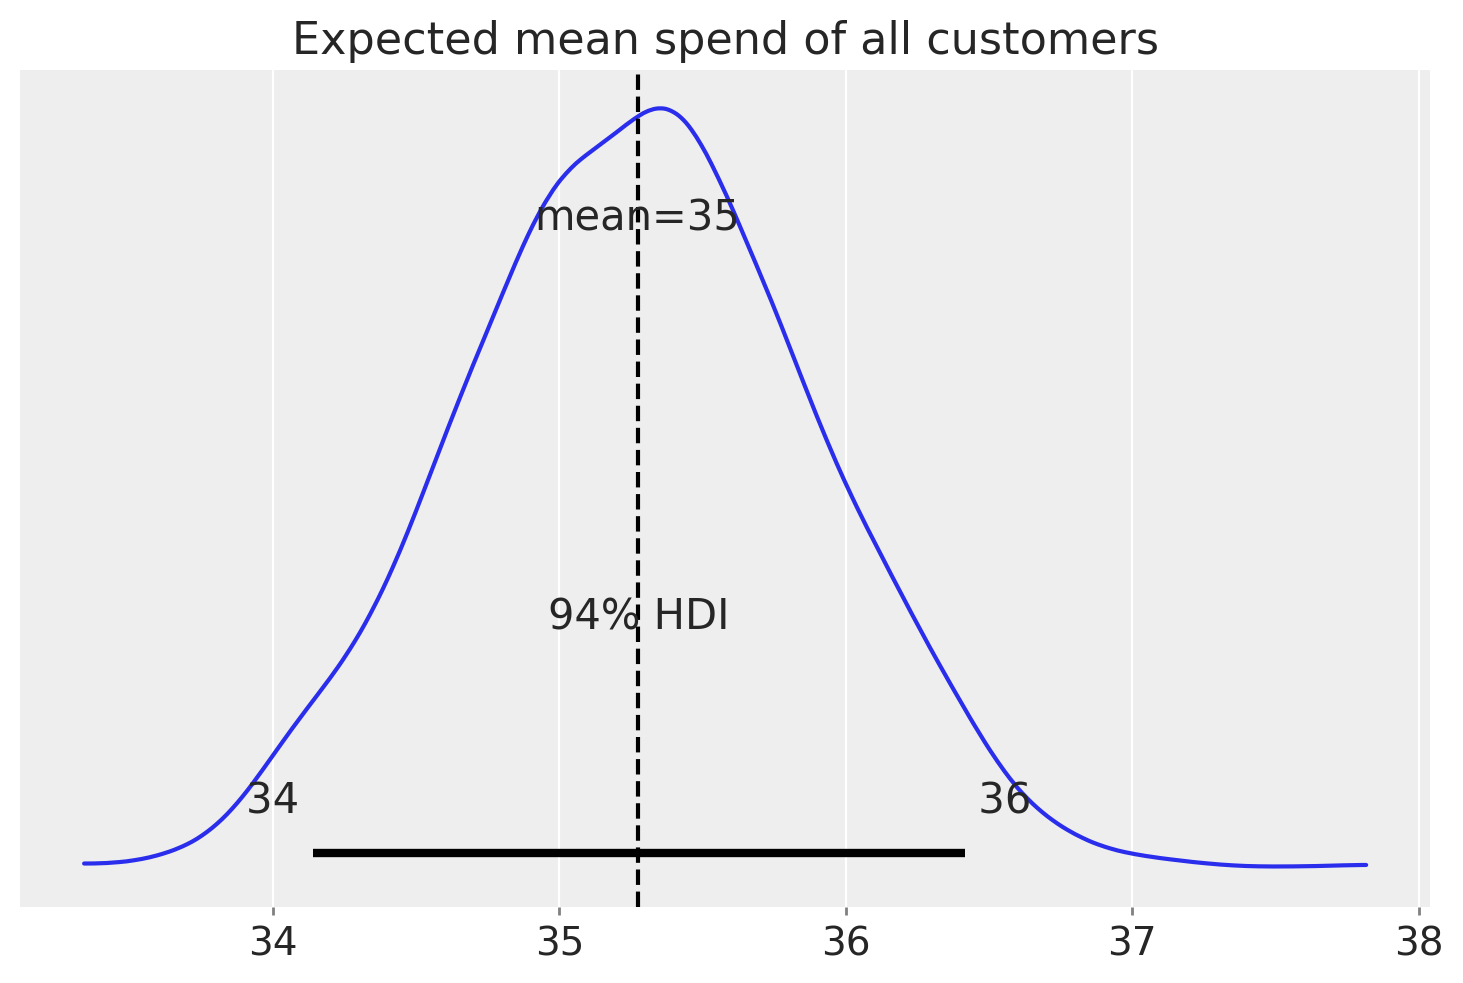

In [27]:
az.plot_posterior(expected_spend.mean("customer_id"))

plt.axvline(expected_spend.mean(), color="k", ls="--")

plt.title("Expected mean spend of all customers");


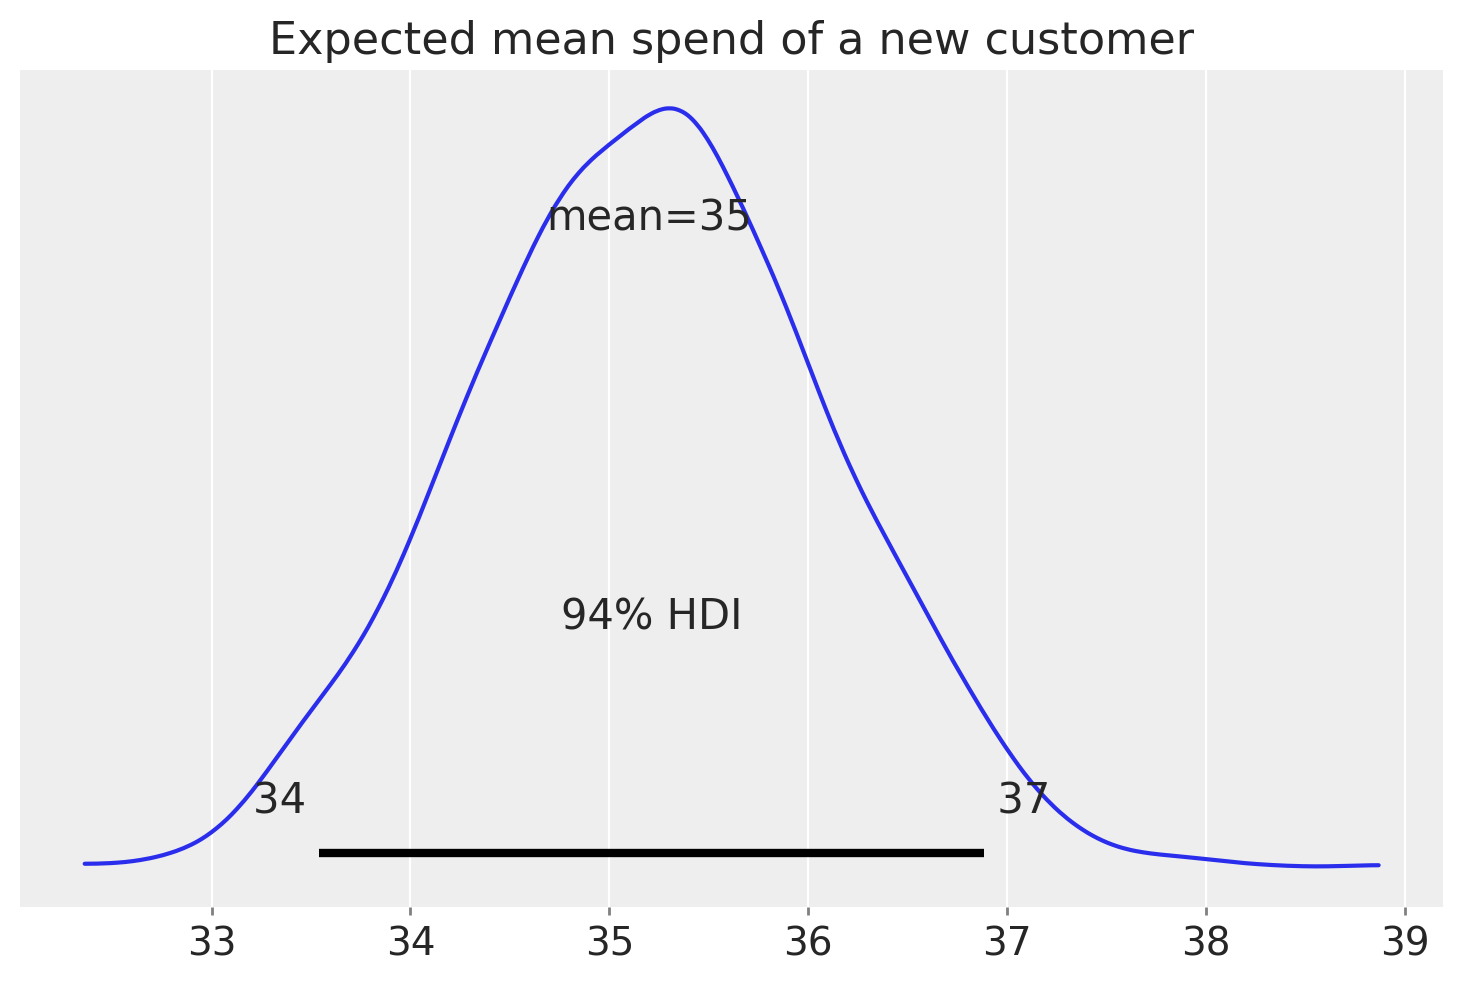

In [28]:
az.plot_posterior(

gg.expected_new_customer_spend()

)
plt.title("Expected mean spend of a new customer");


In [29]:
clv_estimate = gg.expected_customer_lifetime_value(

transaction_model=bgm,

customer_id=data.index,

mean_transaction_value=data["monetary_value"],

frequency=data["frequency"],

recency=data["recency"],

T=data["T"],

time=12,

discount_rate=0.01, # monthly discount rate ~ 12.7% annually

freq="W"

)


In [30]:
az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],36.000,1.641,32.833,38.863
x[2],4.860,0.631,3.692,6.063
x[3],8.415,0.451,7.543,9.218
x[4],8.415,0.451,7.543,9.218
x[5],8.415,0.451,7.543,9.218
x[6],267.098,28.496,213.517,319.319
x[7],7.145,0.800,5.746,8.696
x[8],8.415,0.451,7.543,9.218
x[9],42.985,1.664,39.837,45.940
x[10],8.415,0.451,7.543,9.218


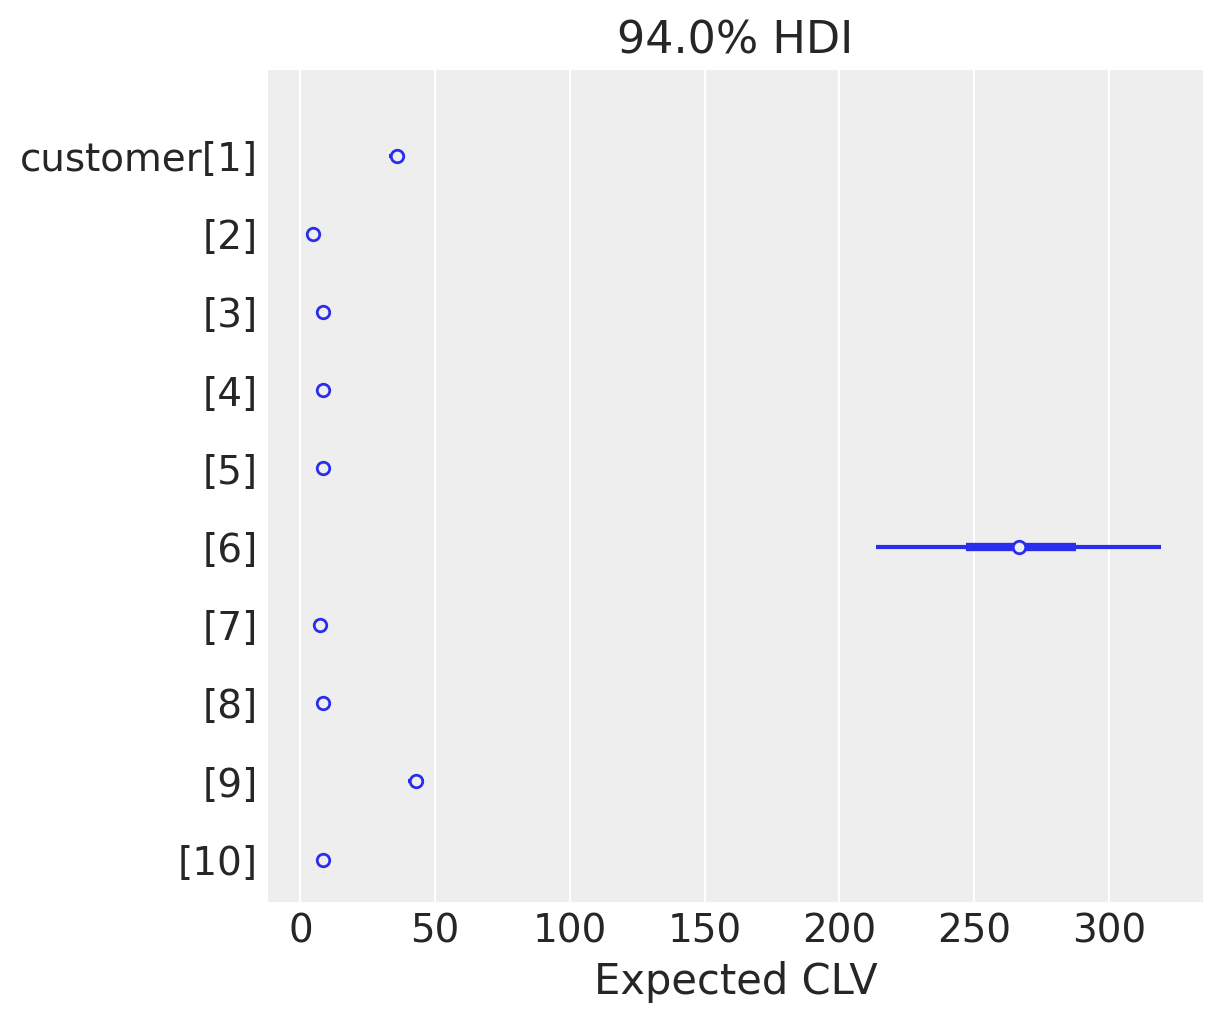

In [31]:
az.plot_forest(clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller)

plt.xlabel("Expected CLV");
